<a href="https://colab.research.google.com/github/anshupandey/MSA-analytics/blob/main/Model_Monitoring/Lab2_Data_Concept_Drift_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪 Lab 2 & Lab 3: Data Drift and Concept Drift Detection
This notebook demonstrates how to simulate **data drift** and **concept drift** on the Ocean Hull Insurance dataset.

We use statistical tests (like KS-test) and concept drift detectors using model prediction behavior.

In [2]:
# Step 1: Load and Prepare Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/anshupandey/MSA-analytics/refs/heads/main/datasets/Ocean_Hull_Insurance_datasetv2.csv"

df = pd.read_csv(url)
df = df.copy()

# Drop ID column
df = df.drop(columns=["Vessel_ID"])
df.head()

,Vessel_Type,Operating_Zone,Vessel_Age,Flag_State,Inspection_Status,Weather_Risk,Piracy_Risk,Claim_Occurred,Claim_Amount,Premium,Sum_Insured,Daily_Return,Initial_Investment,Final_Value
0,Container Ship,Strait of Malacca,19,Marshall Islands,Overdue,Moderate,Moderate,0,0,159500,14050000,0.000997,95700.0,104676.840752
1,Container Ship,Strait of Malacca,40,Marshall Islands,Up-to-date,High,High,0,0,170000,13000000,0.000362,102000.0,105374.760051
2,Tanker,Indian Ocean,26,Greece,Delayed,Low,Low,0,0,193000,18700000,0.001148,115800.0,128393.183954
3,Bulk Carrier,South China Sea,7,Greece,Up-to-date,Moderate,Low,0,0,123500,11650000,0.002023,74100.0,88881.524555
4,Offshore Support Vessel,Mediterranean,18,Liberia,Delayed,Low,Low,0,0,109000,7100000,0.000266,65400.0,66983.429972


## 🔁 Simulate Data Drift: Change in feature distribution
We'll simulate a scenario where weather conditions globally have worsened, so the `Weather_Risk` feature distribution has changed.

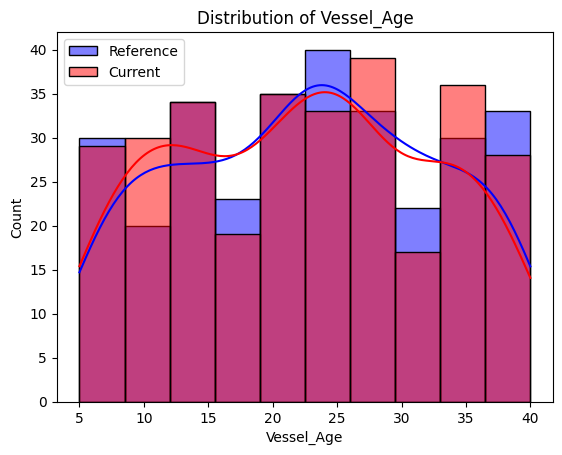

In [10]:
# Step 2: Simulate Data Drift
import numpy as np

# Create two datasets: reference and current
reference_data = df.copy()
current_data = df.copy()

# Simulate drift in Weather_Risk and Vessel_Age
current_data.loc[current_data.sample(frac=0.3).index, 'Weather_Risk'] = 'High'  # randomly setting 30% of values of column weather_risk as "high"
current_data['Vessel_Age'] += np.random.randint(-3, 3, size=current_data.shape[0]) # randomly adding a value between -3 to +3 to vessel age
current_data['Vessel_Age'] = current_data['Vessel_Age'].clip(lower=5, upper=40) # clipping all the values to make it between 5 to 40

# Compare distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reference_data['Vessel_Age'], color='blue', label='Reference', kde=True)
sns.histplot(current_data['Vessel_Age'], color='red', label='Current', kde=True)
plt.title("Distribution of Vessel_Age")
plt.legend()
plt.show()

## 📊 Perform Statistical Test: KS-Test for Drift Detection

### KS Tets = Kolmogorov-Smirnov Test is a non parametric test, can be used to compare a sample of refrence data with a sample of current data (two samples)


- Null Hypothesis: The samples are similar - have similar data distribution
- Alternate Hypothesis: the sampeles are no more similar, have different data distribution

Consider CI = 95%, signgificance level (alpha) = 0.05

P value analysis

- if pvalue < alpha = we sucessfully reject null hypothesis, -> two samples are significantly different - there is a data drift
- if pvalue > alpha = we fail to reject null hypothesis, -> two samples are similar, - there is no data drift

In [11]:
from scipy.stats import ks_2samp

# Compare feature distribution
ks_stat, p_value = ks_2samp(reference_data['Vessel_Age'], current_data['Vessel_Age'])
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("⚠️ Significant data drift detected in Vessel_Age!")
else:
    print("✅ No significant drift in Vessel_Age.")

KS Statistic: 0.0367, p-value: 0.9879
✅ No significant drift in Vessel_Age.


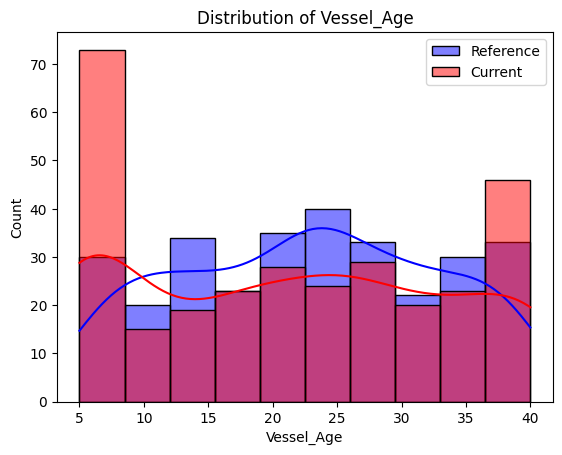

In [12]:
current_data['Vessel_Age'] += np.random.randint(-20, 20, size=current_data.shape[0]) # randomly adding a value between -3 to +3 to vessel age
current_data['Vessel_Age'] = current_data['Vessel_Age'].clip(lower=5, upper=40) # clipping all the values to make it between 5 to 40

# Compare distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reference_data['Vessel_Age'], color='blue', label='Reference', kde=True)
sns.histplot(current_data['Vessel_Age'], color='red', label='Current', kde=True)
plt.title("Distribution of Vessel_Age")
plt.legend()
plt.show()

In [13]:
from scipy.stats import ks_2samp

# Compare feature distribution
ks_stat, p_value = ks_2samp(reference_data['Vessel_Age'], current_data['Vessel_Age'])
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("⚠️ Significant data drift detected in Vessel_Age!")
else:
    print("✅ No significant drift in Vessel_Age.")

KS Statistic: 0.1567, p-value: 0.0012
⚠️ Significant data drift detected in Vessel_Age!


## 🔁 Lab 3: Concept Drift — change in relationship between features and target
We'll simulate a new scenario: weather risk used to be a strong indicator of claims, but now inspection status is more important.

In [ ]:
# Step 3: Train Model on Reference Data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_ref = reference_data.drop(columns=['Claim_Occurred', 'Claim_Amount'])
y_ref = reference_data['Claim_Occurred']

cat_cols = X_ref.select_dtypes(include='object').columns.tolist()
num_cols = X_ref.select_dtypes(include=['int64', 'float64']).columns.tolist()

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline = Pipeline([
    ('preproc', preproc),
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_ref, y_ref)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Vessel_Age', 'Premium',
                                                   'Sum_Insured',
                                                   'Daily_Return',
                                                   'Initial_Investment',
                                                   'Final_Value']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vessel_Type',
                                                   'Operating_Zone',
                                                   'Flag_State',
                                                   'Inspection_Status',
                                                   'Weather_Risk',
                                                   'Piracy_Risk'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [ ]:
# Step 4: Evaluate model on current (drifted) data
X_curr = current_data.drop(columns=['Claim_Occurred', 'Claim_Amount'])
y_curr = current_data['Claim_Occurred']

y_pred = pipeline.predict(X_curr)
print(classification_report(y_curr, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       230
           1       1.00      0.96      0.98        70

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



📉 If performance drops significantly, it indicates **concept drift**.
We can further evaluate drift by checking SHAP values or re-training models and comparing feature importances.